## Problem statement

Scenario: A company's customer service department receives thousands of emails daily through its single support@company.com address. Currently, a team of agents must manually read every email, identify its purpose, and forward it to the correct internal team (e.g., Technical Support, Billing, Sales, or General Inquiry).
Problem: This manual routing process is slow, expensive, and error-prone.

1. Slow: Customers face long delays before their email even reaches the right person, leading to poor satisfaction.
2. Expensive: It requires significant agent-hours just for administrative sorting instead of solving problems.
3. Error-prone: An agent might misclassify an urgent billing issue as a general inquiry, causing further delays and frustration.

## Business Goal: 
To improve customer support efficiency and reduce response times by developing a machine learning model that automatically classifies incoming support emails and routes them to the appropriate department.

## Data Science Goal: 
To build and deploy a multi-class text classification model that accurately predicts the 'Ticket Type' (e.g., 'Technical Issue', 'Billing Inquiry', 'Product Inquiry') based on the email's subject and body text.



In [156]:
#Importing all datascience libraries
import os
import sys
import time
import logging
import argparse
from datetime import datetime
import requests
import json
import threading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [157]:
#Loading dataset
data = pd.read_csv('synthetic_customer_support_tickets.csv')
print("Dataset loaded successfully.")
data.head()

Dataset loaded successfully.


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,10001,Andrea Carpenter,qmitchell@example.org,34,Female,Nespresso Machine,2025-05-08,Billing inquiry,Requesting a refund,I was charged twice for my order of a Nespress...,Open,NaN,Critical,Chat,NaN,NaN,NaN
1,10002,Paul Henderson,hmartinez@example.net,18,Male,Sony WH-1000XM5,2024-12-17,Technical issue,Won't turn on,I bought a Sony WH-1000XM5 and it's not compat...,Open,NaN,Critical,Chat,NaN,NaN,NaN
2,10003,Logan Sharp,kevinprice@example.com,48,Other,Nespresso Machine,2025-06-11,Product inquiry,How do I use Wi-Fi on Nespresso Machine?,I'm interested in buying the Nespresso Machine...,Pending Customer Response,NaN,High,Chat,2025-11-02 04:38:05.217961,NaN,NaN
3,10004,Shelly Harris,jwilcox@example.org,60,Male,Dell XPS,2024-03-14,Account access,Need to change my email,Please help me regain access to my account. My...,Open,NaN,Critical,Email,NaN,NaN,NaN
4,10005,Cory Alvarez,colinramirez@example.com,19,Male,iPhone 15,2025-05-15,Technical issue,Won't turn on,"The device powers on, but the screen is just b...",Closed,Including yard claim gun about window against.,Medium,Social media,2025-10-27 09:38:05.218439,2025-10-28 11:38:05.218439,5.0


In [158]:
#Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     10000 non-null  int64  
 1   Customer Name                 10000 non-null  object 
 2   Customer Email                10000 non-null  object 
 3   Customer Age                  10000 non-null  int64  
 4   Customer Gender               10000 non-null  object 
 5   Product Purchased             10000 non-null  object 
 6   Date of Purchase              10000 non-null  object 
 7   Ticket Type                   10000 non-null  object 
 8   Ticket Subject                10000 non-null  object 
 9   Ticket Description            10000 non-null  object 
 10  Ticket Status                 10000 non-null  object 
 11  Resolution                    3411 non-null   object 
 12  Ticket Priority               10000 non-null  object 
 13  Ti

In [159]:
#Missing data check
missing_data = data.isnull().sum()
print("Missing data in each column:\n", missing_data)


Missing data in each column:
 Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      6589
Ticket Priority                    0
Ticket Channel                     0
First Response Time             3312
Time to Resolution              6589
Customer Satisfaction Rating    6589
dtype: int64


In [160]:
#Duplicates rows check
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [161]:
#Balanced of data check for target class Ticket Type
print("Class distribution:\n", data['Ticket Type'].value_counts())

Class distribution:
 Ticket Type
Product inquiry    2016
Billing inquiry    2015
Technical issue    2012
Account access     1994
General query      1963
Name: count, dtype: int64


### Above analysis shows that the data is quite balanced, has no duplicate entries and there are missing values in 4 columns "Resolution", "First Response Time", "Time to Resolution", and "Customer Satisfaction Rating".

Text(0, 0.5, 'Count')

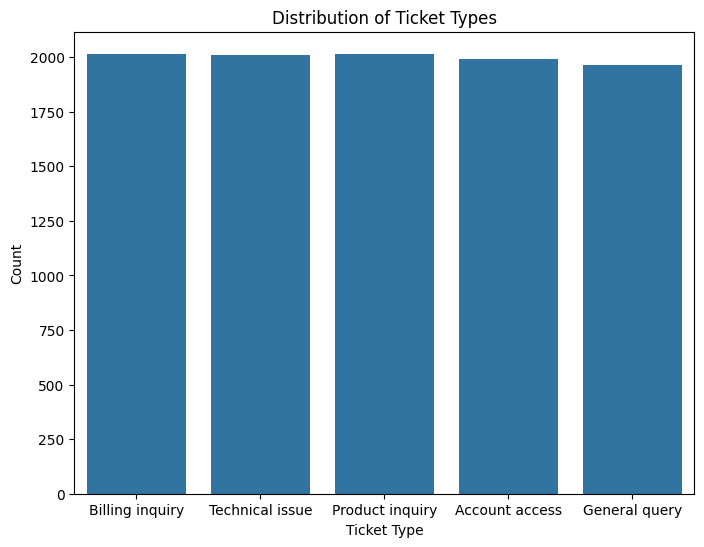

In [162]:
#Visualize the data distribution
plt.figure(figsize=(8,6))
sns.countplot(x='Ticket Type', data=data)
plt.title('Distribution of Ticket Types')
plt.xlabel('Ticket Type')
plt.ylabel('Count')

In [163]:
#Drop columns with too much missing data more than 50-60% and also data which pertains to future information and data leakage
data = data.drop(columns=['Resolution', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating','Ticket Status'])
data.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Priority,Ticket Channel
0,10001,Andrea Carpenter,qmitchell@example.org,34,Female,Nespresso Machine,2025-05-08,Billing inquiry,Requesting a refund,I was charged twice for my order of a Nespress...,Critical,Chat
1,10002,Paul Henderson,hmartinez@example.net,18,Male,Sony WH-1000XM5,2024-12-17,Technical issue,Won't turn on,I bought a Sony WH-1000XM5 and it's not compat...,Critical,Chat
2,10003,Logan Sharp,kevinprice@example.com,48,Other,Nespresso Machine,2025-06-11,Product inquiry,How do I use Wi-Fi on Nespresso Machine?,I'm interested in buying the Nespresso Machine...,High,Chat
3,10004,Shelly Harris,jwilcox@example.org,60,Male,Dell XPS,2024-03-14,Account access,Need to change my email,Please help me regain access to my account. My...,Critical,Email
4,10005,Cory Alvarez,colinramirez@example.com,19,Male,iPhone 15,2025-05-15,Technical issue,Won't turn on,"The device powers on, but the screen is just b...",Medium,Social media


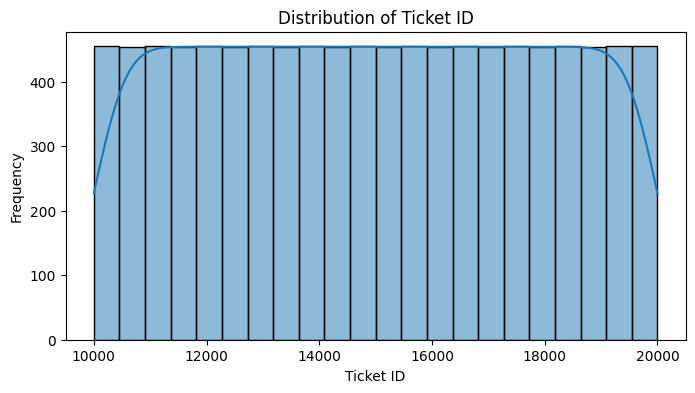

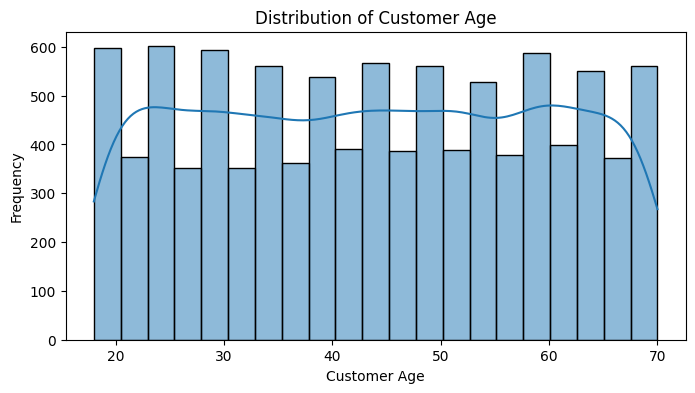

In [164]:
#Numerical variables visualization
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [113]:
!pip install holidays

In [165]:
#Converting "Date of purchase" to Is_weekend, Is_payday and Is_Holiday features
import holidays
us_holidays = holidays.US()
holidays = set(us_holidays.keys())
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], errors='coerce')
data['Is_Weekend'] = data['Date of Purchase'].dt.dayofweek >= 5
data['Is_Payday'] = data['Date of Purchase'].dt.is_month_end
data['Is_Holiday'] = data['Date of Purchase'].dt.date.isin(holidays)
data = data.drop(columns=['Date of Purchase'])
data.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Ticket Type,Ticket Subject,Ticket Description,Ticket Priority,Ticket Channel,Is_Weekend,Is_Payday,Is_Holiday
0,10001,Andrea Carpenter,qmitchell@example.org,34,Female,Nespresso Machine,Billing inquiry,Requesting a refund,I was charged twice for my order of a Nespress...,Critical,Chat,False,False,False
1,10002,Paul Henderson,hmartinez@example.net,18,Male,Sony WH-1000XM5,Technical issue,Won't turn on,I bought a Sony WH-1000XM5 and it's not compat...,Critical,Chat,False,False,False
2,10003,Logan Sharp,kevinprice@example.com,48,Other,Nespresso Machine,Product inquiry,How do I use Wi-Fi on Nespresso Machine?,I'm interested in buying the Nespresso Machine...,High,Chat,False,False,False
3,10004,Shelly Harris,jwilcox@example.org,60,Male,Dell XPS,Account access,Need to change my email,Please help me regain access to my account. My...,Critical,Email,False,False,False
4,10005,Cory Alvarez,colinramirez@example.com,19,Male,iPhone 15,Technical issue,Won't turn on,"The device powers on, but the screen is just b...",Medium,Social media,False,False,False


In [166]:
#Cardinality check in categorical variables except the target variable and "Ticket Description"
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.drop('Ticket Description')
for col in categorical_cols:
    print(f"Cardinality of {col}: {data[col].nunique()}")
    

Cardinality of Customer Name: 9359
Cardinality of Customer Email: 9821
Cardinality of Customer Gender: 3
Cardinality of Product Purchased: 8
Cardinality of Ticket Type: 5
Cardinality of Ticket Subject: 1271
Cardinality of Ticket Priority: 4
Cardinality of Ticket Channel: 4


In [167]:
#Drop the high cardinality categorical columns and also Ticket ID column
data = data.drop(columns=['Customer Name', 'Customer Email', 'Ticket ID'])


In [168]:
#Exporting cleaned data to csv
data.to_csv('cleaned_synthetic_customer_support_tickets.csv', index=False)


## Now re-importing dataset for further analysis

Training model with SEPARATE text features...
Making predictions...
NEW Model Accuracy (Separate Text Columns): 100.00%

Displaying Confusion Matrix:


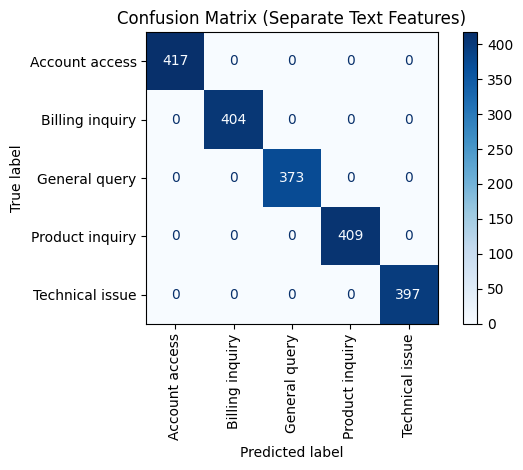

In [169]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the cleaned data (assuming 'cleaned_data' is your DataFrame)
# NOTE: You must run your data cleaning steps first for this to work.
try:
    cleaned_data = pd.read_csv('cleaned_synthetic_customer_support_tickets.csv')
except FileNotFoundError:
    print("Please run your data cleaning notebook cell first, then run this code again.")
    # Exiting or raising an error might be appropriate here in a real script
    # For this example, we'll stop execution gracefully.
    exit()

data = cleaned_data.copy()

# --- KEY FIX 1: Handle NaN values in text columns ---
# TfidfVectorizer will fail on NaN. We must fill them *before* the pipeline.
data['Ticket Subject'] = data['Ticket Subject'].fillna('')
data['Ticket Description'] = data['Ticket Description'].fillna('')

# 2. Define feature groups
categorical_features = [
    'Customer Gender', 
    'Product Purchased', 
    'Ticket Priority', 
    'Ticket Channel'
]
numerical_features = [
    'Customer Age', 
    'Is_Weekend', 
    'Is_Payday', 
    'Is_Holiday'
]

# 3. Create transformers for metadata
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

# 4. Build the new preprocessor
# --- KEY FIX 2: Define SEPARATE transformers for each text column ---
# This is the correct way to treat them independently.
# We can even give them different parameters (e.g., different max_features).
preprocessor = ColumnTransformer(
    transformers=[
        ('subject_text', TfidfVectorizer(stop_words='english', max_features=5000, min_df=5), 'Ticket Subject'),
        ('desc_text', TfidfVectorizer(stop_words='english', max_features=5000, min_df=5), 'Ticket Description'),
        ('categories', categorical_transformer, categorical_features),
        ('numeric', numerical_transformer, numerical_features) 
    ],
    remainder='drop'
)

# 5. Define X and y
# --- KEY FIX 3: X must contain ALL feature columns ---
# The preprocessor selects the columns it needs.
# We only drop the target variable 'Ticket Type'.
X = data.drop(columns=['Ticket Type'])
y = data['Ticket Type']

# 6. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Create and run the full pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

print("Training model with SEPARATE text features...")
model.fit(X_train, y_train)

print("Making predictions...")
y_pred = model.predict(X_test)

print(f"NEW Model Accuracy (Separate Text Columns): {accuracy_score(y_test, y_pred) * 100:.2f}%")

# 8. Display Confusion Matrix
print("\nDisplaying Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix (Separate Text Features)')
plt.tight_layout() # Adjust layout to prevent label overlap
plt.show()

In [172]:
#Reviewing the keywrods in the Ticket Description column and Ticket Subject column
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, min_df=5)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Ticket Description'] + ' ' + data['Ticket Subject'])
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Top 20 keywords by TF-IDF score:")
for idx in tfidf_matrix.sum(axis=0).argsort().A1[-20:][::-1]:
    print(f"{feature_names[idx]}: {tfidf_matrix.sum(axis=0).A1[idx]:.4f}")
    


Top 20 keywords by TF-IDF score:
account: 542.3211
question: 471.2703
order: 430.2804
password: 424.9458
ve: 405.8651
reset: 394.8567
need: 386.9696
tv: 368.8818
invoice: 366.1545
status: 352.1262
just: 343.5806
refund: 330.6151
charge: 329.1136
email: 323.4264
help: 322.7483
support: 316.6992
working: 313.4006
payment: 313.1132
device: 291.4546
ticket: 284.6439
